In [5]:
# Import all required libraries.
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import cv2
import os
from PIL import Image
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from torchsummary import summary


In [6]:
# Filter out the warnings.
import warnings
warnings.filterwarnings("ignore")

In [7]:
images = glob.glob("../data/*/*/*")
images = np.array(images)
labels = np.array([f.split("\\")[-2] for f in images])
classes = np.unique(labels).flatten()
print(classes)

['Bridge' 'Commercial' 'Industrial' 'Intersection' 'Landmark' 'Park'
 'Parking' 'Playground' 'Residential' 'Stadium']


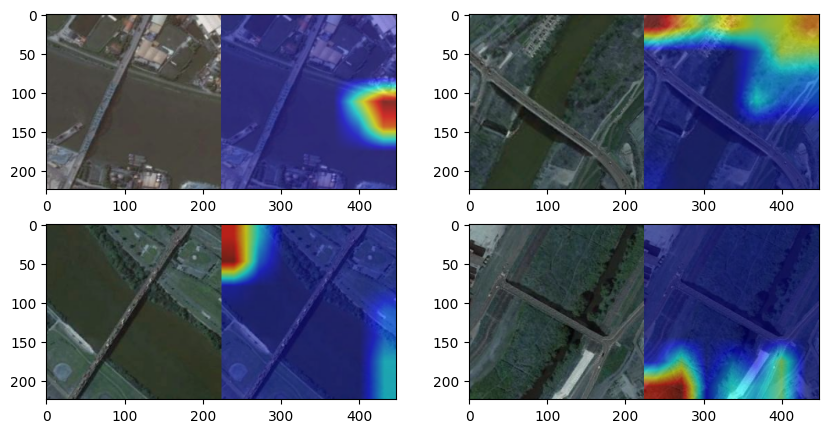

In [8]:
classDir = 'Bridge'
images_dir = f'../data/test/{classDir}/'

# List all files in the directory
all_files = os.listdir(images_dir)

# Filter out the first set of images
image_paths = []
for file in all_files:
    if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
        image_paths.append(os.path.join(images_dir, file))
    if len(image_paths) >= 4:
        break

# Initialize the model
model = models.resnet18(pretrained=True)
model.eval()

# Define the targets and target layers for GradCAM
targets = [ClassifierOutputTarget(np.where(classes == f'{classDir}')[0][0])] 
target_layers = [model.layer4] 

# Initialize lists to store images and heatmaps
images_list = []
heatmaps_list = []

# Generate GradCAM heatmaps for each image
for img_path in image_paths:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    with GradCAM(model=model, target_layers=target_layers) as cam: 
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets) 
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True) 
        
    cam = np.uint8(255*grayscale_cams[0, :]) 
    cam = cv2.merge([cam, cam, cam]) 
    
    images_list.append(np.uint8(255*img))
    heatmaps_list.append(cam_image)

# Create a grid of images
num_images = len(image_paths)
num_cols = 2
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(np.hstack((images_list[i], heatmaps_list[i])))
    else:
        ax.axis('off')

plt.show()